# Exploring the dataset
## Aims
* Understand what each column describes
* Determine if any transforming of the data is required 
* See what the data coverage is for each attribute
* Decide which columns will be used in the MVP implementation

### Read in data

In [228]:
import pandas as pd

Pandas was struggling to automatically determine the correct dtype for the 'Year' column, so I've helped pandas out a bit by providing one.

In [229]:
mortality_pt1_path = r"C:\Users\danny\Development\data\who-mortality-database\Morticd10_part1\Morticd10_part1"
mortality_pt1_df = pd.read_csv(mortality_pt1_path, dtype={'Year': int})
mortality_pt1_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1388106 entries, 0 to 1388105
Data columns (total 39 columns):
Country       1388106 non-null int64
Admin1        84173 non-null float64
SubDiv        0 non-null float64
Year          1388106 non-null int32
List          1388106 non-null object
Cause         1388106 non-null object
Sex           1388106 non-null int64
Frmat         1388106 non-null int64
IM_Frmat      1388106 non-null int64
Deaths1       1388106 non-null int64
Deaths2       1387983 non-null float64
Deaths3       1387983 non-null float64
Deaths4       1328926 non-null float64
Deaths5       1328926 non-null float64
Deaths6       1328926 non-null float64
Deaths7       1387983 non-null float64
Deaths8       1387187 non-null float64
Deaths9       1387983 non-null float64
Deaths10      1387187 non-null float64
Deaths11      1387983 non-null float64
Deaths12      1387187 non-null float64
Deaths13      1387983 non-null float64
Deaths14      1387187 non-null float64
Deaths15    

This is quite a large dataset, with over 1 million rows, and using a considerable amount of memory (407MB for the DF, and my Python instance is listing 1.5GB in task manager), so we may want to consider reading this in in batches if performance becomes an issue.

### Column name descriptions
The following documentation (https://www.who.int/healthinfo/statistics/documentation.zip?ua=1) describes the purpose of each column.
I manually copied the table from the documentation, pasted it into a spreadsheet, and then exported as csv so that it could be more easily processed. 

The following code reads that csv and creates a dict out of it, for use later on should we need to update any of the column names.

In [230]:
import csv

column_names_path = r"C:\Users\danny\Development\data\who-mortality-database\Morticd10_column_names.csv"
column_names_dict = {}

with open(column_names_path, 'r', encoding='utf-8') as f:
    csvreader = csv.reader(f, delimiter=',')
    next(csvreader, None)
    for row in csvreader:
        column_names_dict[row[0]] = row[1]
        
for key, val in column_names_dict.items():
    print(f"{key:12}| {val}")

Country     | Country code – see file “Country_codes.zip”
Admin1      | Specified region/Category pertinent to each country– see Annex Table 2 below. If both fields 'Admin1' and 'Subdiv' are blank, data reported refer to the country.
Subdiv      | Category of data – see Annex Table 2 below. If both fields 'Admin1' and 'Subdiv' are blank, data reported refer to the country.
Year        | Year to which data refer
List        | List of ICD revision used – see Annex Table 2 below.
Cause       | Cause of death – For details consult Part 2 below or ICD publications
Sex         | 1 male, 2 female and 9 sex unspecified
Frmat       | Age-group format for breakdown of deaths at 0-95+ yrs – see Annex Table 1 below for details
IM_Frmat    | Age format for breakdown of infant deaths (0 year) – see Annex Table 1 below for details
Deaths1     | Deaths at all ages
Deaths2     | Deaths at age 0 year
Deaths3     | Deaths at age 1 year
Deaths4     | Deaths at age 2 years
Deaths5     | Deaths at age 3 yea

Most of these definitions are straightforward, however the following table from the documentation shows that the meaning of each Deaths* column isn't consistent across all rows, so will be non-trivial to read (e.g. 'Deaths21' would mean ages 75-79 for a country using Frmat 2, but 75+ in a country using Frmat 7). When these columns are included a more general method of recording age-ranges will be devised.
Annex Table 1 is shown below:
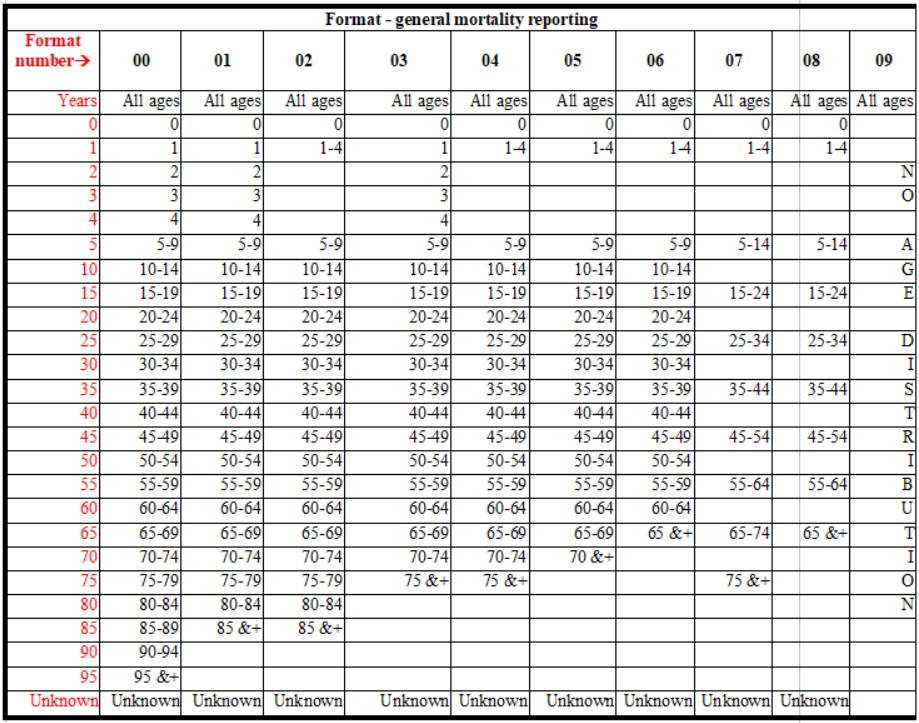

### MVP columns
As an MVP only a subset of these fields are necessary, the fields to continue with are the following:
* Country
* Year
* Cause
* Sex
* Deaths1

In [231]:
mortality_pt1_df = mortality_pt1_df[['Country', 'Year', 'Cause', 'Sex', 'Deaths1']]
mortality_pt1_df.head()

,Country,Year,Cause,Sex,Deaths1
0,1400,2001,1000,1,332
1,1400,2001,1000,2,222
2,1400,2001,1001,1,24
3,1400,2001,1001,2,14
4,1400,2001,1002,1,0


## Improving readability
### Sex
The Sex column uses the following mapping {1:male, 2:female, 9:sex unspecified}. This data will eventually be stores in a PostgreSQL database where a char uses the minimum of one byte, so in the interest of both readability and storage I'm going to map these values to characters instead:

In [232]:
sex_map = {1: 'm',
          2: 'f',
          9: 'u'}

mortality_pt1_df['Sex'] = mortality_pt1_df['Sex'].map(sex_map)
mortality_pt1_df.head()

,Country,Year,Cause,Sex,Deaths1
0,1400,2001,1000,m,332
1,1400,2001,1000,f,222
2,1400,2001,1001,m,24
3,1400,2001,1001,f,14
4,1400,2001,1002,m,0


The Country and Cause columns currently use codes which aren't convenient for a human to read. At a cost in storage efficiency, I'm going to replace these with the string definition provided in the documentation.
### Cause
Read in cause codes plus cause description as a dictionary and update the Cause column

In [233]:
cause_codes_path = r"C:\Users\danny\Development\data\who-mortality-database\ICD10_Mortality_Tabulation_List_1.csv"
cause_codes_dict = {}
with open(cause_codes_path, 'r', encoding='utf-8') as f:
    csvreader = csv.reader(f, delimiter=',')
    next(csvreader, None)
    for row in csvreader:
        cause_codes_dict[row[0]] = row[2]
        
mortality_pt1_df['Cause'] = mortality_pt1_df['Cause'].astype(str).map(cause_codes_dict)
mortality_pt1_df.head()

,Country,Year,Cause,Sex,Deaths1
0,1400,2001,All causes,m,332
1,1400,2001,All causes,f,222
2,1400,2001,Certain infectious and parasitic diseases,m,24
3,1400,2001,Certain infectious and parasitic diseases,f,14
4,1400,2001,Cholera,m,0


### Country
Read in country codes plus country name as a dictionary and update the Country column

In [234]:
country_codes_path = r"C:\Users\danny\Development\data\who-mortality-database\country_codes\country_codes"
country_codes_dict = {}

with open(country_codes_path, 'r', encoding='utf-8') as f:
    csvreader = csv.reader(f, delimiter=',')
    next(csvreader, None)
    for row in csvreader:
        country_codes_dict[row[0]] = row[1]
        
mortality_pt1_df['Country'] = mortality_pt1_df['Country'].astype(str).map(country_codes_dict)
mortality_pt1_df.head()

,Country,Year,Cause,Sex,Deaths1
0,Seychelles,2001,All causes,m,332
1,Seychelles,2001,All causes,f,222
2,Seychelles,2001,Certain infectious and parasitic diseases,m,24
3,Seychelles,2001,Certain infectious and parasitic diseases,f,14
4,Seychelles,2001,Cholera,m,0
